# NCI60 Copy Number Data Importation
**Local Version**: 1
**Source Version**: NA

This notebook will import raw NCI60 copy number data using the [Cell Miner R](http://bioconductor.statistik.tu-dortmund.de/packages/3.4/data/experiment/manuals/rcellminerData/man/rcellminerData.pdf) package.

In [1]:
%run -m ipy_startup
%run -m ipy_seaborn
%load_ext rpy2.ipython
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import na_utils
from py_utils import collection_utils as cu
from py_utils.collection_utils import subset

In [2]:
%%R 
# Load CellMiner package containing necessary data
library('rcellminerData')

In [3]:
%%R -o d
# Load NCI60 expression data
# Note that a similar alternative to molData@eSetList$exp is molData@eSetList$xai, indicated in the documentation as 
# "Expression (Avg. log2 Intensity).".  Given that the values for this alternative are always positive, the 
# assumption is being made here that that the "xai" value is a log2 concentration without comparison to a control 
# tissue sample which makes it less useful and less compatible with a typical expression value where the log2 value 
# is the ratio of the expression for the tumor sample over the control tissue sample.
d <- as.data.frame(molData@eSetList$cop)

In [4]:
d.index.name = 'CELL_LINE_ID'
d = d.reset_index()
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 23414 entries, CELL_LINE_ID to ZZZ3
dtypes: float64(23413), object(1)
memory usage: 10.7+ MB


In [5]:
d.head()

,CELL_LINE_ID,A1BG,A1BG.AS1,A1CF,A2M,A2M.AS1,A2ML1,A2MP1,A3GALT2,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,BR:MCF7,0.106893,0.106893,0.012714,-0.005491,-0.005491,-0.005491,-0.005491,-0.273495,-0.127657,...,0.274454,-0.067839,-0.413593,-0.413593,0.148135,-0.407221,-0.407221,0.084881,0.093322,-0.484228
1,BR:MDA_MB_231,0.066333,0.066333,0.069241,-0.268109,-0.268109,-0.268109,-0.268109,-0.206787,-0.212926,...,-0.204051,0.069241,-0.179924,-0.179924,-0.238972,-0.217412,-0.217412,0.071552,0.091436,0.500913
2,BR:HS578T,0.152615,0.152615,-0.203771,-0.176512,-0.176512,-0.176512,-0.176512,0.192132,0.416512,...,-0.145493,-0.255333,-0.634831,-0.634831,0.359257,0.131022,0.131022,0.144014,0.236257,0.096535
3,BR:BT_549,0.231484,0.231484,0.040896,-0.069155,-0.069155,-0.069155,-0.069155,0.249094,-0.021923,...,-0.348117,0.018481,-0.308832,-0.308832,-0.030500,0.205319,0.205319,-0.063268,0.244132,0.199594
4,BR:T47D,-0.213149,-0.213149,0.316086,-0.792709,-0.792709,-0.792709,-0.792709,-0.234215,-0.205247,...,0.089733,0.257851,-0.140103,-0.140103,0.111579,-0.239398,-0.239398,-0.328012,-0.224428,-0.298998


In [6]:
na_utils.get_null_stats(d)

{'n': 1404840,
 'n_non_null': 1402159,
 'n_null': 2681,
 'pct_null': 0.19084023803422454}

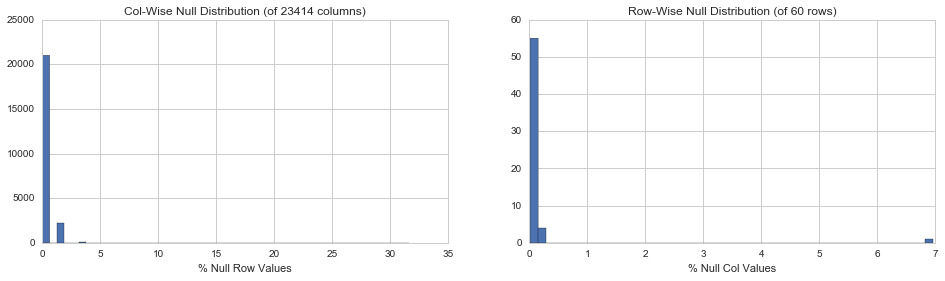

In [8]:
na_utils.plot_dim_null_frequencies(d)

In [9]:
d = pd.melt(d, id_vars='CELL_LINE_ID', var_name='GENE_ID', value_name='VALUE')
assert d.groupby(['CELL_LINE_ID', 'GENE_ID']).size().max() == 1
d = subset(d, lambda df: df[df['VALUE'].notnull()], subset_op='Remove null values for column "VALUE"')
d.head()

[Remove null values for column "VALUE"] Records before = 1404780, Records after = 1402099, Records removed = 2681 (%0.19)


,CELL_LINE_ID,GENE_ID,VALUE
0,BR:MCF7,A1BG,0.106893
1,BR:MDA_MB_231,A1BG,0.066333
2,BR:HS578T,A1BG,0.152615
3,BR:BT_549,A1BG,0.231484
4,BR:T47D,A1BG,-0.213149


In [10]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402099 entries, 0 to 1404779
Data columns (total 3 columns):
CELL_LINE_ID    1402099 non-null object
GENE_ID         1402099 non-null object
VALUE           1402099 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.8+ MB


In [11]:
assert d['CELL_LINE_ID'].nunique() == 60, 'Did not find data for exactly 60 cell lines'
d['CELL_LINE_ID'].nunique()

60

In [12]:
assert np.all(pd.notnull(d))
db.save(d, src.NCI60_v1, db.RAW, 'gene-copy-number')

'/Users/eczech/data/research/mgds/raw/nci60_v1_gene-copy-number.pkl'